In [7]:
import os
import numpy as np
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import pyopencl as cl

In [8]:
seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

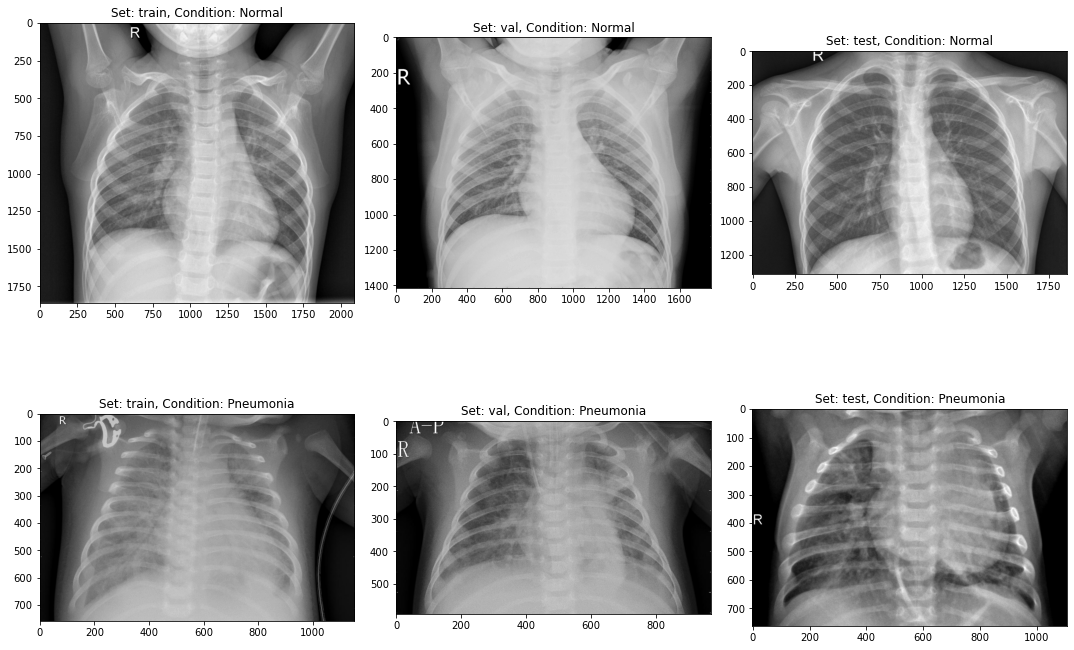

In [9]:
path = './chest_xray/'

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.ravel()
plt.tight_layout()
for i, _set in enumerate(['train', 'val', 'test']):
    set_path = path + _set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))

    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [10]:
def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
    )

    test_val_datagen = ImageDataGenerator(
        rescale=1./255
    )

    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
        directory=path + 'train',
        target_size=(img_dims, img_dims),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
        directory=path + 'test',
        target_size=(img_dims, img_dims),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True)

    val_gen = test_val_datagen.flow_from_directory(
        directory=path + 'val',
        target_size=(img_dims, img_dims),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True)

    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(path + 'test' + cond)):
            img = plt.imread(path + 'test' + cond + img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond == '/NORMAL/':
                label = 0
            elif cond == '/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)

    test_data = np.array(test_data)
    test_labels = np.array(test_labels)

    return train_gen, test_gen, val_gen, test_data, test_labels

In [12]:
# Constants
img_dims = 150
epochs = 2
batch_size = 32

train_gen, test_gen, val_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [17]:
# SYCL initialization
platforms = cl.get_platforms()
devices = platforms[0].get_devices()

print("Available OpenCL devices:")
for i, device in enumerate(devices):
    print("Device", i, ":", device.name.strip())

ctx = cl.Context([devices[0]])
queue = cl.CommandQueue(ctx)

# Model architecture
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_dims, img_dims, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.summary()

# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Setting up callbacks
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_loss', save_weights_only=True, mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_delta=0.0001, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=6, mode='min', verbose=1)

callbacks = [checkpoint, reduce_lr, early_stopping]

# Training the model
hist = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=val_gen.samples // batch_size,
    callbacks=callbacks
)

# Evaluating the model on the test set
score = model.evaluate(test_gen, verbose=1)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])


Available OpenCL devices:
Device 0 : NVIDIA GeForce RTX 3070 Laptop GPU
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 74, 74, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

20/20 [==============================] - 1s 64ms/step
CONFUSION MATRIX ------------------
[[162  72]
 [ 26 364]]

TEST METRICS ----------------------
Accuracy: 84.2948717948718%
Precision: 83.4862385321101%
Recall: 93.33333333333333%
F1-score: 88.13559322033898

TRAIN METRIC ----------------------
Train acc: 84.85


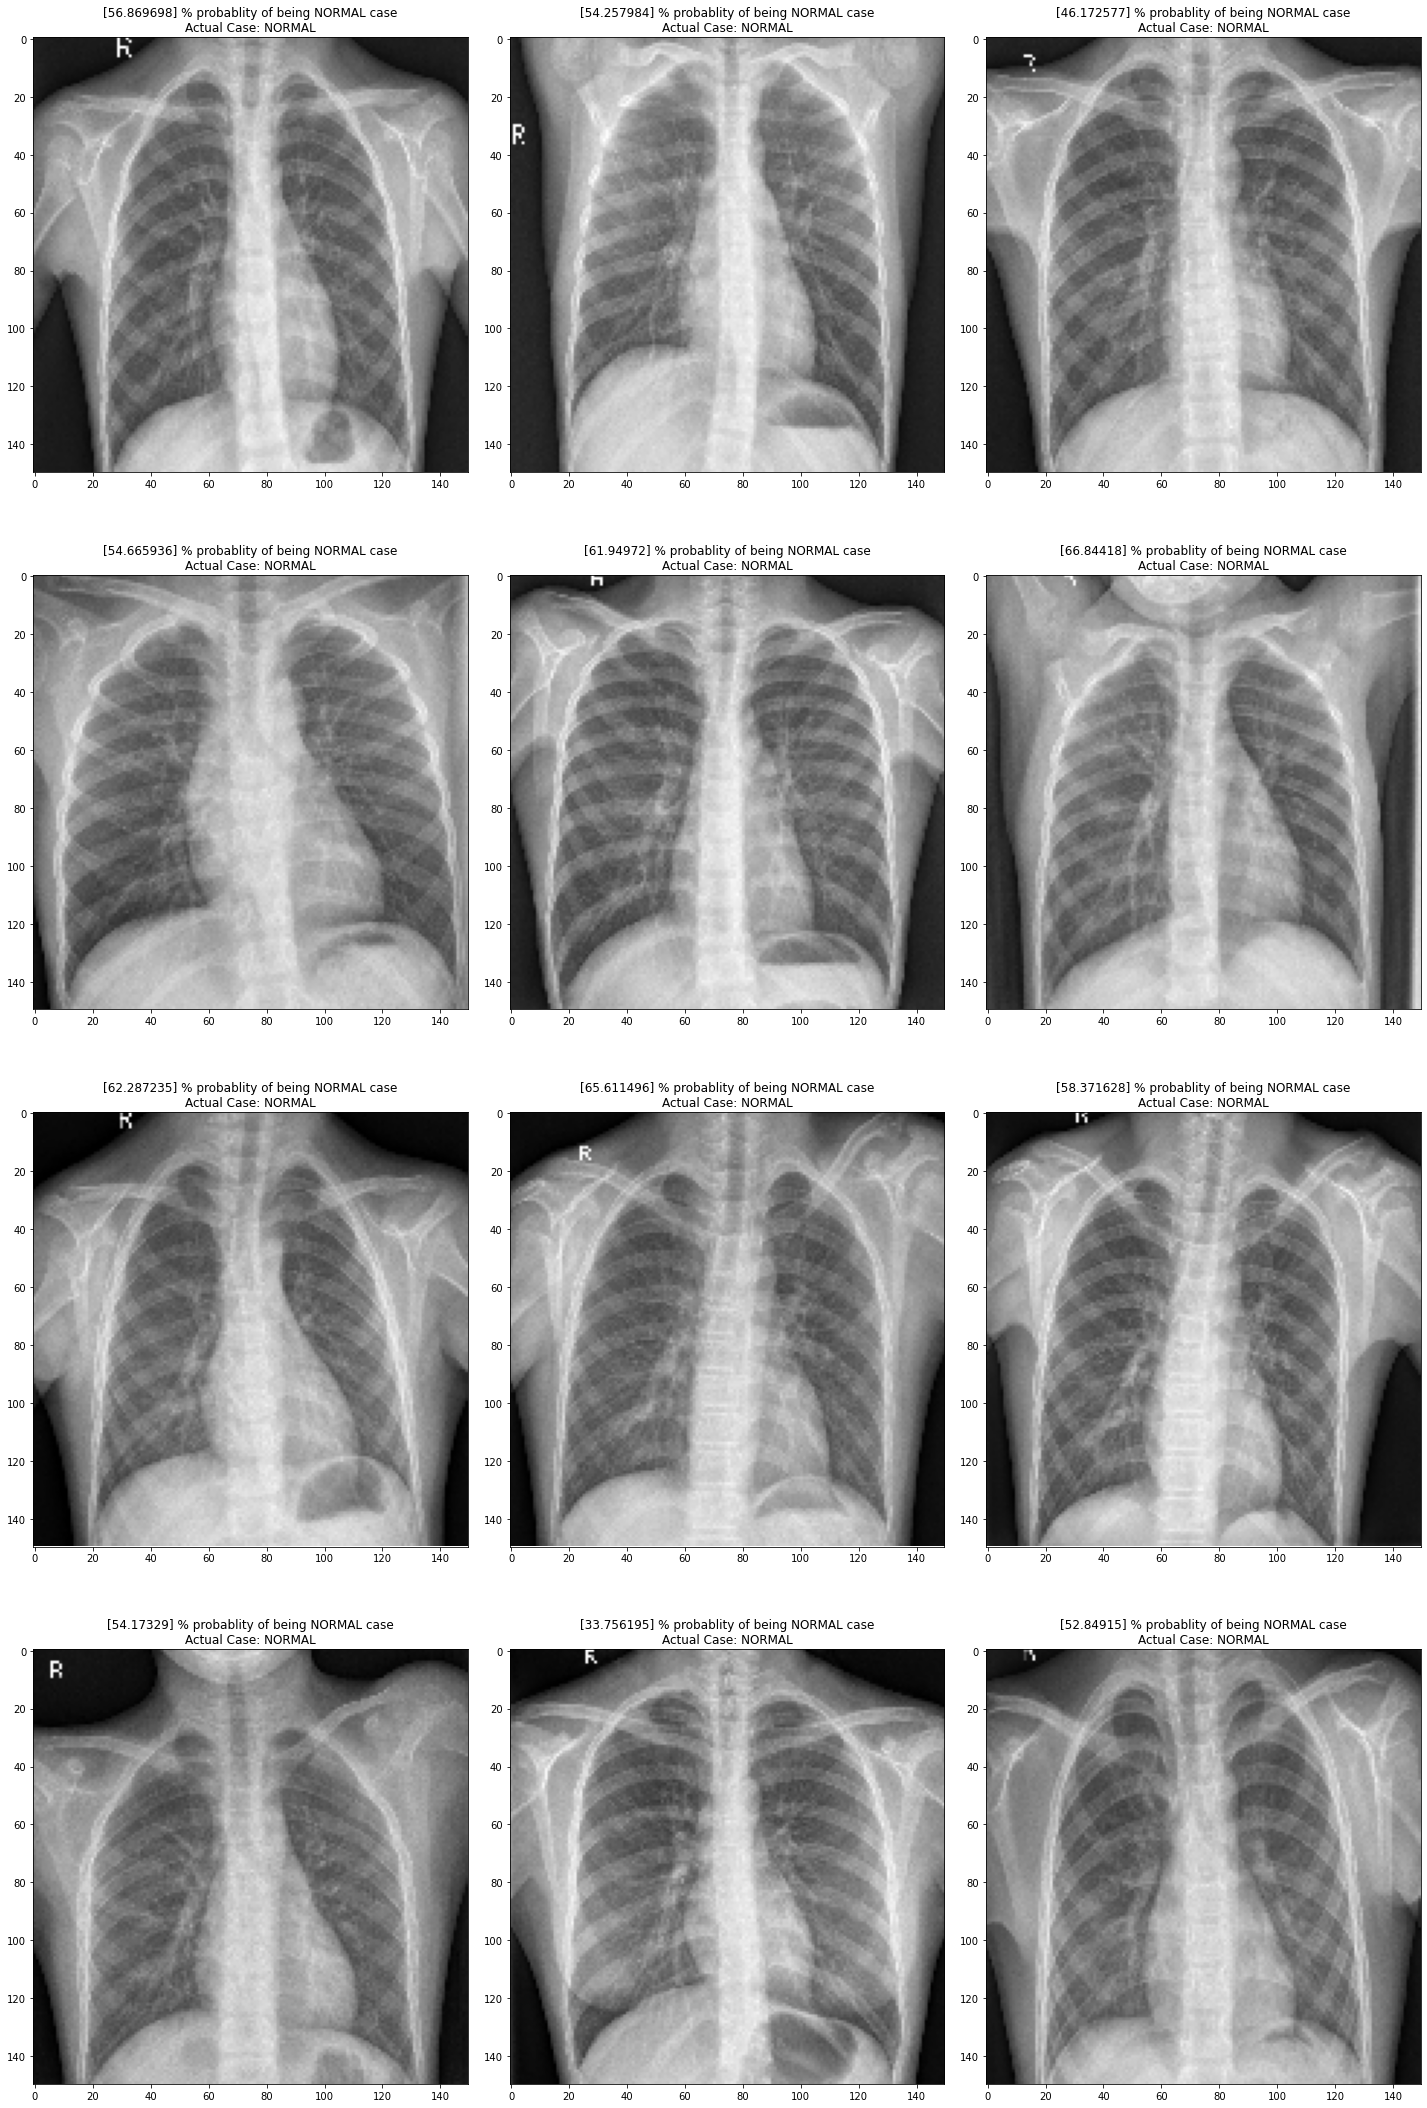

In [28]:
fig, ax = plt.subplots(4, 3, figsize=(20, 30))
ax = ax.ravel()
plt.tight_layout()

for i in range(12):
    ax[i].imshow(test_data[i], cmap='gray')
    
    if test_labels[i] == 0:
        ax[i].set_title('{} % probablity of being NORMAL case'.format((1 - preds[i])*100) + '\n' + 'Actual Case: NORMAL')
    else:
        ax[i].set_title('{} % probablity of being PNEUMONIA case'.format(preds[i]*100) + '\n' + 'Actual Case: PNEUMONIA')

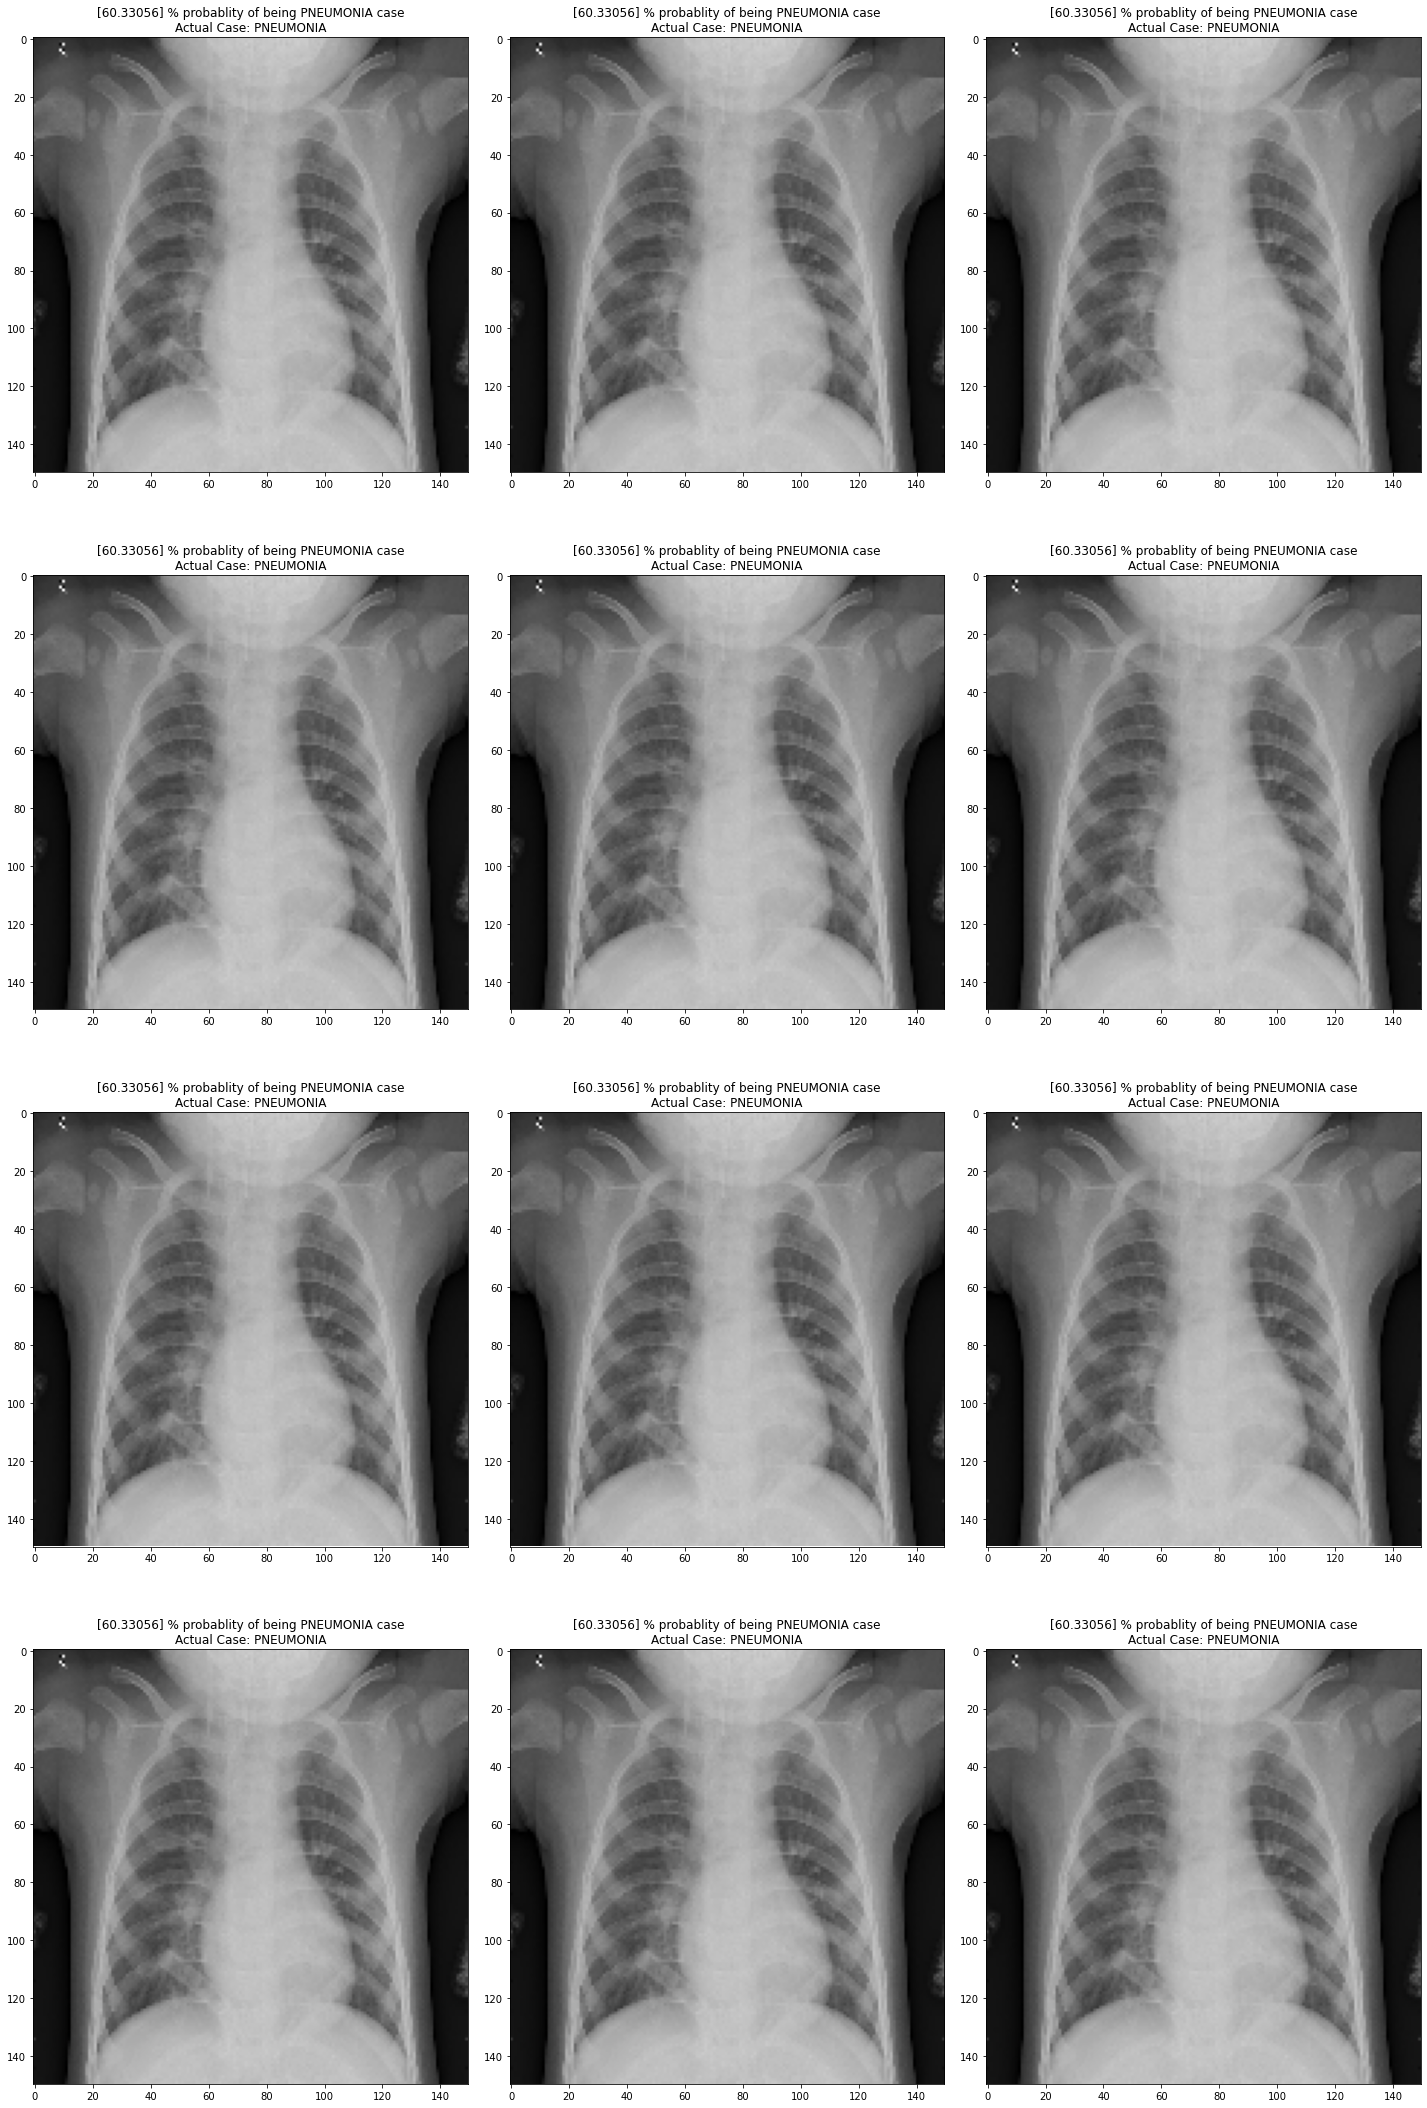

In [29]:
fig, ax = plt.subplots(4, 3, figsize=(20, 30))
ax = ax.ravel()
plt.tight_layout()

for i in range(12):
    for j in range(234, 246):
        ax[i].imshow(test_data[j])
    
        if test_labels[j] == 0:
            ax[i].set_title('{} % probablity of being NORMAL case'.format((1 - preds[j])*100) + '\n' + 'Actual Case: NORMAL')
        else:
            ax[i].set_title('{} % probablity of being PNEUMONIA case'.format(preds[j]*100) + '\n' + 'Actual Case: PNEUMONIA')